# SETUP

In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
%tensorflow_version 1.14.0
from tensorflow import keras

from tensorflow.keras import *
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
from sklearn import metrics
from random import randrange


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PLATE GENERATION SETUP

In [3]:
# Run this command only once:

# makes the output folder /content/pictures/
!mkdir pictures

# Run this command only once

# Downloads the license plate template to /content/blank_plate.png
!gdown --id 1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v

Downloading...
From: https://drive.google.com/uc?id=1Q_FsX2z6DaDCLM91qGZzwvctaW9bN60v
To: /content/blank_plate.png
100% 144k/144k [00:00<00:00, 35.5MB/s]


In [4]:
path = "/content/"

NUMBER_OF_PLATES = 1

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype(font="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 
                                   size=165)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             blank_plate)

# DATA REPRESENTATION

In [20]:
def blur(img, amount):
  output_img=cv2.GaussianBlur(img, (amount,amount), 0)
  return output_img

In [21]:
def rotate_image(img, angle):
  image_center = tuple(np.array(img.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

In [22]:
def shear(img):
  rows, cols, dim = img.shape
  M = np.float32([[1, 0.05, 0],
             	[-0.05, 1  , 0],
            	[0, 0  , 1]])
  sheared_img = cv2.warpPerspective(img,M,(int(cols),int(rows)))
  return sheared_img

In [23]:
def raze(img, inter):
  Wkernel = np.ones((10,1),np.uint8)
  Tkernel = np.ones((1,5),np.uint8)
  kernel = np.ones((5,5), np.uint8)
  i = cv2.erode(img, Tkernel, iterations = inter)
  i = cv2.dilate(i,kernel, iterations= inter)
  return i

In [24]:
#salt and pepper noise used from https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv
def sp_noise(img, factor):
  row,col,dim = img.shape
  ratio = 0.3
  amount = 1.0 * factor
  out = np.copy(img)

  num_salt = np.ceil(amount * img.size * ratio)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img.shape]
  out[coords] = 1
  
  num_pepper = np.ceil(amount* img.size * (1. - ratio))
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img.shape]
  out[coords] = 0
  return out

In [25]:
def get_plate_characters(plate):
  filtered =[]
  
  lp_img = cv2.cvtColor(plate[:, 30:plate.shape[1]-50], cv2.COLOR_BGR2HSV)

  #Add random blur or rotation
  # lp_img = blur(lp_img)
  # lp_img = rotate_image(lp_img, 6)
  # perspective change
  # albumentations

  i = cv2.inRange(lp_img, (117,117, 0), (255,255,255))
  Wkernel = np.ones((10,1),np.uint8)
  Tkernel = np.ones((1,5),np.uint8)
  kernel = np.ones((5,5), np.uint8)
  i = cv2.erode(i, Tkernel, iterations = 1)
  i = cv2.dilate(i,kernel, iterations= 1)
  # i = cv2.threshold(i, 5, 255, cv2.THRESH_BINARY)
  # i = np.float32(i) 
  filtered.append(i)
  # plt.imshow(i)

  letters = []
  for img in filtered:    
    contours, _hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(filter(lambda x : cv2.arcLength(x, True) > 200, contours))
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    for i, c in enumerate(contours):
      contours_poly[i] = cv2.approxPolyDP(c, 3, True)
      boundRect[i] = cv2.boundingRect(contours_poly[i])
      
    boundRect = list(filter(lambda x : x[2]*x[3]>5000, boundRect))
    boundRect = sorted(boundRect, key = lambda x : x[2]*x[3], reverse=True)[:4]
    boundRect = sorted(boundRect, key = lambda x : x[0])
    
    if len(boundRect) < 4:
      return False, []
      
    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    for i in range(len(boundRect)):
      color = (255,255,255)
      cv2.drawContours(drawing, contours_poly, i, color)
      cv2.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
                (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
      
    for i in range(len(boundRect)):
      x,y,w,h = boundRect[i]
      # fprint(w*h)
      im = img[y:y+h , x:x+w]

      Lkernel = np.ones((5,5), np.uint8)
      Skernel = np.ones((3,3), np.uint8) 
      im = cv2.erode(im,Skernel, iterations= 2)
      im = cv2.dilate(im,Lkernel, iterations= 1)

      im = np.expand_dims(im, axis=2)
      backtorgb = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)
      ret, backtorgb = cv2.threshold(backtorgb, 100, 1, cv2.THRESH_BINARY)
      binarized = np.around(np.float32(cv2.cvtColor(backtorgb,cv2.COLOR_RGB2GRAY)))
      
      letters.append(binarized)
  return True, letters


In [26]:
path = "/content/"

class license_plate():
    """
    Contains a randomly generated license plate with the format AA##
    Contains a 
    """
    def __init__(self, text = None, blurred = 0, angle = 0, sheared = False, sp = 0, razed = 0):
        
        for i in range(0, 1):
            if text is None or len(text) != 4:    
                # Pick two random letters
                plate_alpha = ""
                for _ in range(0, 2):
                    plate_alpha += (random.choice(string.ascii_uppercase))

                # Pick two random numbers
                num = randint(0, 99)
                plate_num = "{:02d}".format(num)
            else:
                pass
            
            # Write plate to image
            blank_plate = cv2.imread(path+'blank_plate.png')
            #print(blank_plate.shape)
            # Convert into a PIL image (this is so we can use the monospaced fonts)
            blank_plate_pil = Image.fromarray(blank_plate)

            # Get a drawing context
            draw = ImageDraw.Draw(blank_plate_pil)
            monospace = ImageFont.truetype(font="/content/drive/MyDrive/ENPH 353/NN/UbuntuMono-R.ttf", 
                                        size=165)
            if text is None or len(text) != 4:
                draw.text(xy=(48, 75),
                        text=plate_alpha + "  " + plate_num, 
                        fill=(255,0,0), font=monospace)
                self.text = plate_alpha + str(plate_num)
            else:
                draw.text(xy=(48, 75),
                        text=text[:2] + "  " + text[2:], 
                        fill=(255,0,0), font=monospace)
                self.text = text

            # Convert back to OpenCV image and save
            blank_plate = np.array(blank_plate_pil)

            # Write license plate to file #I decided to generate new images every time
            # cv2.imwrite(os.path.join(path + "pictures/", 
            #                         "plate_{}{}.png".format(plate_alpha, plate_num)),
            #                         blank_plate)

        self.picture = blank_plate
        if blurred != 0:
          self.picture = blur(self.picture, blurred)
        if angle != 0:
          self.picture = rotate_image(self.picture, angle)
        if sheared == True:
          self.picture = shear(self.picture)
        if sp != 0:
          self.picture = sp_noise(self.picture, sp)
        if razed != 0:
          self.picture = raze(self.picture, razed)
        
        self.str_to_vector(self.text)
        self.section_BW_picture()
    
    def section_BW_picture(self):
        picture = self.picture
        success, i=get_plate_characters(picture)
        self.letter_imgs=[]
        if success is True:
          width=95
          height=125
          dim=(width, height)
          r1=np.expand_dims(cv2.resize(i[0], dim, interpolation = cv2.INTER_AREA), axis = 2)
          r2=np.expand_dims(cv2.resize(i[1], dim, interpolation = cv2.INTER_AREA), axis = 2)
          r3=np.expand_dims(cv2.resize(i[2], dim, interpolation = cv2.INTER_AREA), axis = 2)
          r4=np.expand_dims(cv2.resize(i[3], dim, interpolation = cv2.INTER_AREA), axis = 2)
    

          self.letter_imgs.append(r1)
          self.letter_imgs.append(r2)
          self.letter_imgs.append(r3)
          self.letter_imgs.append(r4)

    def str_to_vector(self, s):
        self.vectorized_text = []
        for c in s:
            vec = np.zeros(36)
            tmp = ord(c)
            if tmp >= 48 and tmp < 65:
                vec[tmp-48] = 1
                self.vectorized_text.append(vec)
            elif tmp >= 65:
                vec[tmp-55] = 1
                self.vectorized_text.append(vec)

    def vector_to_str(vector):
        """
        returns the character that the input vector represents
        """
        max = np.argmax(vector)
        if max >= 10: 
            return chr(max+55)
        else:
            return chr(max+48)

# MODEL CREATION

In [27]:
model = None
model = keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = "relu", input_shape = (125,95,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation= "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(36, activation="softmax"))

LEARNING_RATE = 1e-4
model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])
#reset_weights(model)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 93, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 46, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40832)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40832)             0         
_________________________________________

# MODEL TRAINING

In [28]:
data = []
for i in range(100):
    data.append(license_plate())

for i in range(50):
    data.append(license_plate(None, 45, 0, False))

for i in range(50):
    angle = randrange(-10,10)
    data.append(license_plate(None, 25, angle, False))

for i in range(50):
    data.append(license_plate(None, 25, 0, True))

for i in range(200):
    data.append(license_plate(None, 35, 4, False, 0, 2))
    data.append(license_plate(None, 35, 0, False, 0.15, 0))
    data.append(license_plate(None, 35, 0, False, 0.1, 2))

for i in range(5):
    data.append(license_plate("II11", 35, -5, False, 0.15, 2))
    data.append(license_plate("ZZ77", 35, 5, False, 0.15, 2))
    data.append(license_plate("BB33", 35, 0, False, 0.15, 2))
    data.append(license_plate("JJ88", 35, 0, False,0.15,2))

for i in range(2):
  data.append(license_plate("SS55"))
  data.append(license_plate("SS55", 35, 5, False, 0, 2))
  data.append(license_plate("SS55", 35, 0, False, 0.1, 2))
  data.append(license_plate("VN27", 35, 20, False, 0.15, 1))
  data.append(license_plate("VN26", 15, 20, False, 0.15, 0))
  data.append(license_plate("VN26", 35, 15, True, 0.15, 1))

for lp in data:
  if lp.letter_imgs == [] or len(lp.letter_imgs) != 4 or len(lp.vectorized_text) != 4:
    data.remove(lp)

np.random.shuffle(data)
print(len(data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


863


In [29]:
imgs =[]
vtexts = []
for lp in data:
    imgs += lp.letter_imgs
    vtexts += lp.vectorized_text

ar_imgs=np.array(imgs)
ar_vtexts=np.array(vtexts)

history_conv = model.fit(ar_imgs, ar_vtexts,
                         validation_split=0.1,
                         epochs=20,
                         batch_size=16)

Train on 3106 samples, validate on 346 samples
Epoch 1/20
3106/3106 [==============================] - 10s 3ms/sample - loss: 0.4993 - acc: 0.8892 - val_loss: 0.0286 - val_acc: 0.9942
Epoch 2/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 0.0299 - acc: 0.9907 - val_loss: 0.0572 - val_acc: 0.9884
Epoch 3/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 0.0095 - acc: 0.9977 - val_loss: 0.0413 - val_acc: 0.9855
Epoch 4/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 0.0037 - acc: 0.9987 - val_loss: 0.0738 - val_acc: 0.9827
Epoch 5/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 0.0012 - acc: 0.9997 - val_loss: 0.0121 - val_acc: 0.9971
Epoch 6/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 0.0050 - acc: 0.9994 - val_loss: 0.0349 - val_acc: 0.9855
Epoch 7/20
3106/3106 [==============================] - 6s 2ms/sample - loss: 3.2612e-04 - acc: 0.9997 - val_loss: 0.0630 - val_acc: 0.9

# MODEL RESULTS

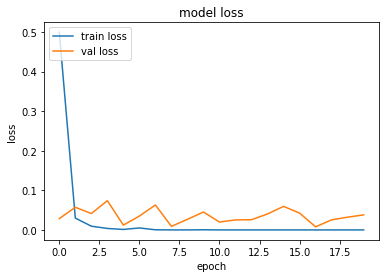

In [30]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

In [31]:
from ipywidgets import interact
import ipywidgets as ipywidgets

new_data = []
new_imgs =[]
new_vtexts = []

for i in range(1000):
    new_data.append(license_plate())
    for lp in new_data:
      if lp.letter_imgs == []:
        new_data.remove(lp)

for lp in new_data:
  for j in lp.letter_imgs:
    i=j
    i=i.reshape(125,95,1)
    new_imgs.append(i)
  new_vtexts += (lp.vectorized_text)

# Display images in the training data set. 
def displayImage(index):
    lp = new_data[index]
    
    #img_aug = np.expand_dims(img, axis=0)
    text = ""
    for img in lp.letter_imgs:
        
        #plt.imshow(img)
        img = img.reshape(125,95,1)
        img = np.expand_dims(img, axis=0)
        text += license_plate.vector_to_str(model.predict(img))
    
    plt.imshow(cv2.cvtColor(lp.picture, cv2.COLOR_BGR2RGB))  
    plt.text(0, 0, "Prediction: " + text,
             color='orange', fontsize = 16,
             horizontalalignment='left', verticalalignment='bottom')

interact(displayImage, index=ipywidgets.IntSlider(min=0, max=len(new_data),step=1, value=10))

interactive(children=(IntSlider(value=10, description='index', max=1000), Output()), _dom_classes=('widget-int…

<function __main__.displayImage>

In [32]:
prediction = []
ground_truth = []

for lp in new_data:
    for img in lp.letter_imgs:
        img = img.reshape(125,95,1)
        img = np.expand_dims(img, axis=0)
        prediction.append(license_plate.vector_to_str(model.predict(img)[0]))
    for char in lp.text:
        ground_truth.append(char)

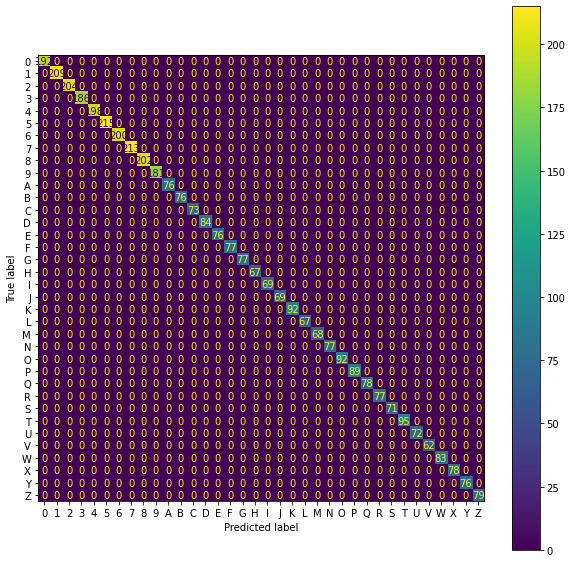

In [33]:
prediction = np.array(prediction)
ground_truth = np.array(ground_truth)
labels = []
for i in range(10):
    labels.append(i)
for i in range(26):
    labels.append(chr(i + 65))
matrix = metrics.confusion_matrix(ground_truth, prediction)
plt.rcParams["figure.figsize"] = (10,10)
metrics.ConfusionMatrixDisplay(matrix, display_labels = labels).plot()
plt.show()

In [ ]:
model.save("Letter_Identification_NN.h5", include_optimizer=False)

# EXTRA DATA TESTING

In [35]:
PATH="/content/drive/MyDrive/ENPH 353/LP Letters/"
letters = []
for i in range (0,100):
  img = plt.imread(PATH+'letter_'+str(i)+'.png')
  img = cv2.resize(img, (95,125), interpolation = cv2.INTER_AREA)
  letters.append(img)

data = []
for img in letters:
  img = img.reshape(125,95,1)
  img = np.expand_dims(img, axis=0)
  data.append(img)

In [36]:
prediction = []
for i in range (len(data)):
  prediction.append(license_plate.vector_to_str(model.predict(data[i])[0]))
print(prediction)

['L', 'Y', '5', '6', 'L', 'Y', '5', '6', 'L', 'Y', '5', '6', 'L', 'Y', '5', '6', '1', 'B', '3', '0', 'I', 'B', '3', '0', 'I', 'B', '3', '0', 'I', 'B', '3', '0', 'I', 'B', '3', '0', 'I', 'B', '3', '0', 'I', 'B', '3', '0', 'Z', 'Y', '7', 'I', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'Z', 'Y', '7', '1', 'R', 'K', '1', '7', 'R', 'K', '1', '7', 'R', 'K', '1', '7']


In [37]:
from ipywidgets import interact
import ipywidgets as ipywidgets

new_data = []
new_imgs =[]
new_vtexts = []

# Display images in the training data set. 
def displayImage(index):
    img = data[index]
    
    #img_aug = np.expand_dims(img, axis=0)
    text = ""
   
        
    #plt.imshow(img)
    img = img.reshape(125,95,1)
    img = np.expand_dims(img, axis=0)
    text += license_plate.vector_to_str(model.predict(img))
    
    plt.imshow(cv2.cvtColor(letters[index], cv2.COLOR_BGR2RGB))  
    plt.text(0, 0, "Prediction: " + text,
             color='orange', fontsize = 16,
             horizontalalignment='left', verticalalignment='bottom')

interact(displayImage, index=ipywidgets.IntSlider(min=0, max=len(data),step=1, value=10))

interactive(children=(IntSlider(value=10, description='index'), Output()), _dom_classes=('widget-interact',))

<function __main__.displayImage>

# FUNCTION TESTING

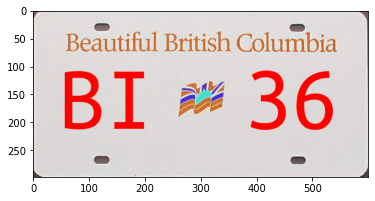

In [ ]:
lp = license_plate("BI36")
# print(lp.letter_imgs)
# i = cv2.resize(lp.letter_imgs[2], (95,125), interpolation = cv2.INTER_AREA)
plt.imshow(lp.picture)

In [ ]:
parking_spot_plates = {"1": [], "2": [], "3": [], "4": [], "5": [], "6": []}
parking_spot_plates["1"].append("AJ24")
print(parking_spot_plates["1"])

['AJ24']


In [ ]:
parking_spots = ["1","2","3","4"]
print(parking_spots[1])

2


In [ ]:
s1 = "ab45"
s2 = "ab45"
s3 = "ad45"
s4 = "ab45"
s5 = "ad46"

plates = []
plates.append(s1)
plates.append(s2)
plates.append(s3)
plates.append(s4)
plates.append(s5)

from collections import Counter
word_counts = Counter(plates)
top = word_counts.most_common(1)
print(top[0][0])

ab45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


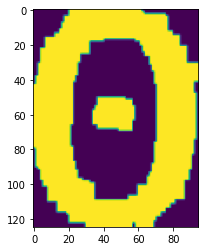

In [ ]:
lp=license_plate("VA00", 35, 0, False, 0.1, 2)
plt.imshow(lp.picture)
i = cv2.resize(lp.letter_imgs[2], (95,125), interpolation = cv2.INTER_AREA)
plt.imshow(i)

# lp2=license_plate(None, False, 4)
# lp3=license_plate()

# plt.imshow(lp.letter_imgs[0])

# img = lp.letter_imgs[0]
# plt.imshow(img)
# plt.show()
# img = np.expand_dims(img, axis=2)
# backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
# ret, backtorgb = cv2.threshold(backtorgb, 50, 1, cv2.THRESH_BINARY)
# backtorgb = np.float32(cv2.cvtColor(backtorgb,cv2.COLOR_RGB2GRAY))
# print(backtorgb)
# plt.imshow(backtorgb)
